In [ ]:
# Install dependencies
!pip install -U torch torchvision
!pip install Pillow==5.3.0
!pip install --upgrade --no-cache-dir gdown

In [58]:
# imports
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image

import os
import random
import pickle

from pathlib import Path
from tqdm import tqdm, tqdm_notebook

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [2]:
# verify that GPU is enabled for this notebook
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    DEVICE = torch.device("cpu")
    print('CUDA is not available.  Training on CPU ...')
else:
    DEVICE = torch.device("cuda")
    print('CUDA is available!  Training on GPU ...')

!nvidia-smi

CUDA is available!  Training on GPU ...
Thu Apr 14 07:06:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [3]:
# Use seed=42 to reproduce
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
# download dataset
!gdown https://drive.google.com/uc?id=1dJ-ks91AXSX10kfnUiOJfFNaSmH5hhKm -O simpsons.zip

Downloading...
From: https://drive.google.com/uc?id=1dJ-ks91AXSX10kfnUiOJfFNaSmH5hhKm
To: /content/simpsons.zip
100% 546M/546M [00:03<00:00, 137MB/s]


In [5]:
# unzip archive
!unzip -q /content/simpsons.zip -d simpsons

In [6]:
%cd simpsons
!ls

/content/simpsons
characters_illustration.png  sample_submission.csv  testset  train


In [95]:
# use correct image folders
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# split data
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels, random_state=seed)

In [8]:
# create label encoder
label_encoder = LabelEncoder()
label_encoder.fit([path.parent.name for path in train_val_files])

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(label_encoder, le_dump_file)

In [9]:
label_encoder.classes_

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [10]:
IMG_SIZE = 224
IMG_MEAN = np.array([0.4607, 0.4045, 0.3495]) # np.array([0.485, 0.456, 0.406])
IMG_STD = np.array([0.2545, 0.2313, 0.2630]) # np.array([0.229, 0.224, 0.225])

# find dataset mean and std
def get_mean_std():
    mean = torch.zeros((3,), dtype=torch.float64)
    std = torch.zeros((3,), dtype=torch.float64)
    n = 0
    
    for file in train_val_files:
        image = Image.open(file)
        image.load()
        image_tensor = transforms.ToTensor()(image)
        mean += torch.sum(image_tensor, dim=(1, 2))
        std += torch.sum(image_tensor**2, dim=(1, 2))
        n += image_tensor.shape[1] * image_tensor.shape[2]

    mean = mean / n
    std = torch.sqrt(std / n - (mean ** 2))
    return mean, std

# print(get_mean_std())
# (tensor([0.4607, 0.4045, 0.3495], dtype=torch.float64), tensor([0.2545, 0.2313, 0.2630], dtype=torch.float64))

In [97]:
# Fix SimpsonsDataset:
#   do not use label_encoder
#   change transformations
#   balance classes
class SimpsonsDataset(Dataset):
    """
    Dataset loads images by path, transforms them and returns tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        self.mode = mode
        self.files = self.balance(files)      
        
        DATA_MODES = ['train', 'val', 'test']
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.transform_ = transforms.Compose(list( \
            self.get_train_transforms() if self.mode == 'train' else \
            self.get_eval_transforms()))
                                   
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def balance(self, files):
        if (self.mode != 'train'):
            return files
        
        # find distribution
        classes = {}
        for file in files:
            class_name = file.parent.name
            class_items = classes.setdefault(class_name, [])
            class_items.append(file)

        max_class_len = len(max(classes.values(), key=lambda x: len(x)))

        # add 10% of difference from biggest class
        balanced_files = []
        for class_items in classes.values():
            class_len = len(class_items)
            balanced_len = class_len + int(0.1 * (max_class_len - class_len))
            balanced_files.extend(random.choices(class_items, k=balanced_len))

        return balanced_files

    def get_train_transforms(self):
        yield transforms.Resize((int(1.1 * IMG_SIZE), int(1.1 * IMG_SIZE)))
        yield transforms.RandomCrop(IMG_SIZE)        
        yield transforms.RandomHorizontalFlip(0.25)
        yield transforms.ColorJitter(brightness=0.2, contrast=0.2)

        yield transforms.ToTensor();
        yield transforms.Normalize(IMG_MEAN, IMG_STD);
    
    def get_eval_transforms(self):
        yield transforms.Resize((IMG_SIZE, IMG_SIZE));
        
        yield transforms.ToTensor();
        yield transforms.Normalize(IMG_MEAN, IMG_STD);
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform_(x)
        if self.mode == 'test':
            return x
        else:
            label = self.files[index].parent.name
            return x, label

In [98]:
# create all datasets
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [13]:
# show some images
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = IMG_STD * inp + IMG_MEAN
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

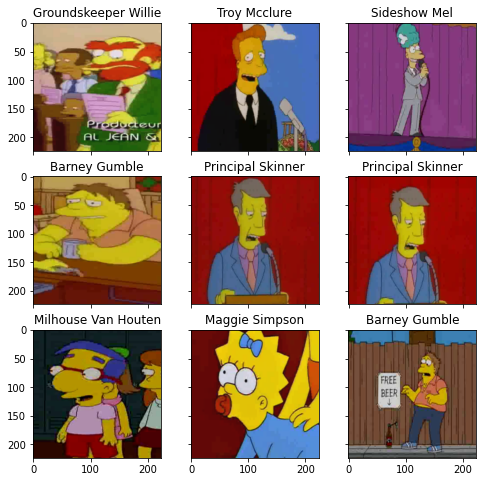

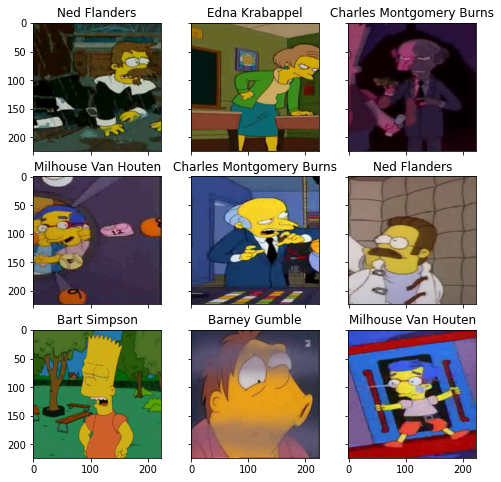

In [ ]:
def show_random_image_from(dataset):
  fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
  for fig_x in ax.flatten():
      random_characters = int(np.random.uniform(0,len(dataset)))
      im_val, label = dataset[random_characters]
      img_label = " ".join(map(lambda x: x.capitalize(), label.split('_')))
      imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

show_random_image_from(train_dataset)
show_random_image_from(val_dataset)

In [108]:
# Fix net:
#   change layers (~AlexNet)
#   add batch norm and dropout
#   todo: onnx js doesn't want to work with BatchNorm1d
class SimpleCnn(nn.Module):  
    def __init__(self, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # 2
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # 3
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # 4
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 5
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.fc = nn.Sequential(
            # 1
            nn.Linear(256, 1024),
            nn.Dropout(p=0.1),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            # 2
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            # 3
            nn.Linear(1024, n_classes))        
  
    def forward(self, x):
        x = self.conv(x)        
        x = torch.flatten(x, 1)
        return self.fc(x)

In [99]:
# fit/eval
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = torch.asarray(label_encoder.transform(labels)).to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [100]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = torch.asarray(label_encoder.transform(labels)).to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [101]:
# fix train method:
#   remove unused parameters
#   add learning rate schedular
#   save models
def train(model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = ExponentialLR(opt, gamma=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step()

            torch.save(model.state_dict(), f'model-{epoch + 1}.pt')
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [102]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [109]:
# create net
simple_cnn = SimpleCnn(len(label_encoder.classes_)).to(DEVICE)
simple_cnn

SimpleCnn(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 96, kernel_size=(5, 5), stride=(2, 2))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(128, 64, kernel_s

In [110]:
# train
history = train(model=simple_cnn, epochs=20, batch_size=32)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.408324627156448


epoch:   5%|▌         | 1/20 [05:06<1:37:11, 306.94s/it]


Epoch 001 train_loss: 2.4083     val_loss 1.6862 train_acc 0.3366 val_acc 0.5187
loss 1.4025144440949928


epoch:  10%|█         | 2/20 [10:10<1:31:30, 305.05s/it]


Epoch 002 train_loss: 1.4025     val_loss 1.1362 train_acc 0.5880 val_acc 0.6582
loss 0.965060080862522


epoch:  15%|█▌        | 3/20 [15:14<1:26:18, 304.60s/it]


Epoch 003 train_loss: 0.9651     val_loss 1.0589 train_acc 0.7085 val_acc 0.6948
loss 0.7227281620466396


epoch:  20%|██        | 4/20 [20:17<1:21:03, 303.98s/it]


Epoch 004 train_loss: 0.7227     val_loss 0.8080 train_acc 0.7828 val_acc 0.7757
loss 0.5473808574999299


epoch:  25%|██▌       | 5/20 [25:21<1:15:57, 303.85s/it]


Epoch 005 train_loss: 0.5474     val_loss 0.7375 train_acc 0.8369 val_acc 0.7896
loss 0.44629484634991823


epoch:  30%|███       | 6/20 [30:27<1:11:04, 304.60s/it]


Epoch 006 train_loss: 0.4463     val_loss 0.7593 train_acc 0.8646 val_acc 0.7927
loss 0.3554282859594102


epoch:  35%|███▌      | 7/20 [35:31<1:05:59, 304.57s/it]


Epoch 007 train_loss: 0.3554     val_loss 0.7772 train_acc 0.8926 val_acc 0.8034
loss 0.29186429759378235


epoch:  40%|████      | 8/20 [40:32<1:00:39, 303.32s/it]


Epoch 008 train_loss: 0.2919     val_loss 0.7413 train_acc 0.9104 val_acc 0.8202
loss 0.24337224460298978


epoch:  45%|████▌     | 9/20 [45:37<55:41, 303.77s/it]


Epoch 009 train_loss: 0.2434     val_loss 0.6965 train_acc 0.9264 val_acc 0.8264
loss 0.21380119641149858


epoch:  50%|█████     | 10/20 [50:37<50:27, 302.70s/it]


Epoch 010 train_loss: 0.2138     val_loss 0.7028 train_acc 0.9355 val_acc 0.8292
loss 0.16727321502093234


epoch:  55%|█████▌    | 11/20 [55:37<45:16, 301.81s/it]


Epoch 011 train_loss: 0.1673     val_loss 0.7225 train_acc 0.9492 val_acc 0.8381
loss 0.14832589151244618


epoch:  60%|██████    | 12/20 [1:00:39<40:14, 301.77s/it]


Epoch 012 train_loss: 0.1483     val_loss 0.6900 train_acc 0.9540 val_acc 0.8448
loss 0.12105736138612103


epoch:  65%|██████▌   | 13/20 [1:05:42<35:15, 302.21s/it]


Epoch 013 train_loss: 0.1211     val_loss 0.7500 train_acc 0.9639 val_acc 0.8469
loss 0.11027623602701635


epoch:  70%|███████   | 14/20 [1:10:43<30:10, 301.78s/it]


Epoch 014 train_loss: 0.1103     val_loss 0.7153 train_acc 0.9671 val_acc 0.8498
loss 0.09345100280975382


epoch:  75%|███████▌  | 15/20 [1:15:45<25:09, 301.82s/it]


Epoch 015 train_loss: 0.0935     val_loss 0.7413 train_acc 0.9718 val_acc 0.8469
loss 0.0728053771883077


epoch:  80%|████████  | 16/20 [1:20:51<20:12, 303.09s/it]


Epoch 016 train_loss: 0.0728     val_loss 0.7549 train_acc 0.9786 val_acc 0.8522
loss 0.0702944684453271


epoch:  85%|████████▌ | 17/20 [1:26:11<15:24, 308.20s/it]


Epoch 017 train_loss: 0.0703     val_loss 0.7367 train_acc 0.9789 val_acc 0.8572
loss 0.06458994167570166


epoch:  90%|█████████ | 18/20 [1:31:16<10:14, 307.48s/it]


Epoch 018 train_loss: 0.0646     val_loss 0.7339 train_acc 0.9808 val_acc 0.8612
loss 0.0498034020754545


epoch:  95%|█████████▌| 19/20 [1:36:17<05:05, 305.44s/it]


Epoch 019 train_loss: 0.0498     val_loss 0.7602 train_acc 0.9854 val_acc 0.8586
loss 0.048217033627514304


epoch: 100%|██████████| 20/20 [1:41:21<00:00, 304.08s/it]


Epoch 020 train_loss: 0.0482     val_loss 0.7908 train_acc 0.9854 val_acc 0.8600


In [111]:
loss, acc, val_loss, val_acc = zip(*history)

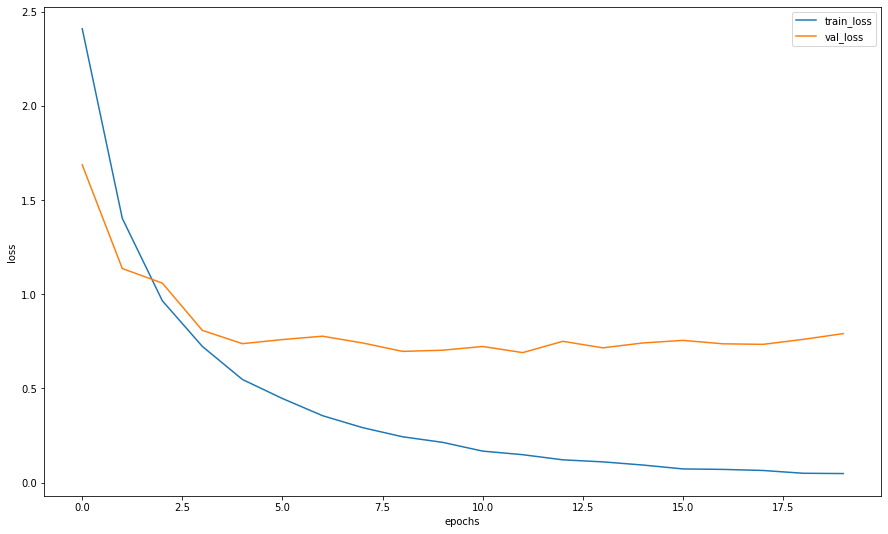

In [112]:
# plot
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

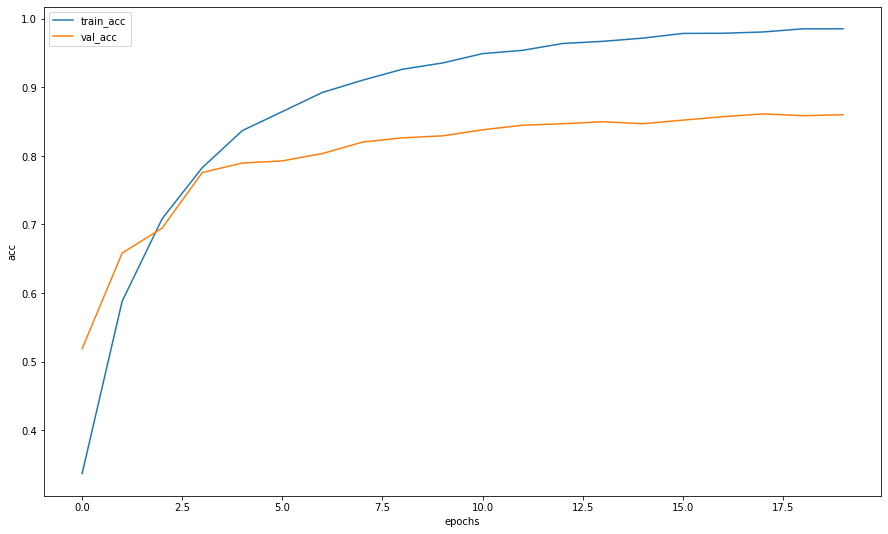

In [113]:
# plot
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot([x.to('cpu') for x in val_acc], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [116]:
# test and save
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('my_simple_cnn_baseline.csv', index=False)

In [117]:
# load some previous models
model = SimpleCnn(len(label_encoder.classes_))
model.load_state_dict(torch.load("model-12.pt"))
model = model.to(DEVICE)
model.eval()

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('my_simple_cnn_baseline (12).csv', index=False)

In [114]:
# for onnx js
class SimpleCnnEx(nn.Module):  
    def __init__(self, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # 2
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # 3
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # 4
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 5
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.fc = nn.Sequential(
            # 1
            nn.Linear(256, 1024),
            nn.Dropout(p=0.1),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            # 2
            nn.Linear(1024, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            # 3
            nn.Linear(1024, n_classes)) 
  
    def forward(self, x):
        x = x / 255
        x = x.reshape(224, 224, 4)
        x = x.transpose(1, 2).transpose(0, 1)
        x = torch.narrow(x, dim=0, start=0, length=3)  
        x = x.reshape(1, 3, 224, 224)
        x = transforms.Normalize(IMG_MEAN, IMG_STD)(x)
        
        x = self.conv(x)        
        x = torch.flatten(x, 1)
        return self.fc(x)

In [115]:
model = SimpleCnnEx(len(label_encoder.classes_))
model.load_state_dict(torch.load("model-18.pt"))
model.eval()

dummy_input = torch.zeros(4*224*224)
torch.onnx.export(model, dummy_input, "model-20.onnx", verbose=True)

graph(%0 : Float(200704, strides=[1], requires_grad=0, device=cpu),
      %fc.0.weight : Float(1024, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc.0.bias : Float(1024, strides=[1], requires_grad=1, device=cpu),
      %fc.3.weight : Float(1024, 1024, strides=[1024, 1], requires_grad=1, device=cpu),
      %fc.3.bias : Float(1024, strides=[1], requires_grad=1, device=cpu),
      %fc.5.weight : Float(42, 1024, strides=[1024, 1], requires_grad=1, device=cpu),
      %fc.5.bias : Float(42, strides=[1], requires_grad=1, device=cpu),
      %79 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %80 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %82 : Float(96, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=0, device=cpu),
      %83 : Float(96, strides=[1], requires_grad=0, device=cpu),
      %85 : Float(128, 96, 3, 3, strides=[864, 9, 3, 1], requires_grad=0, device=cpu),
      %86 : Float(128, strides=[1], requires_grad=0, device=c